# v2.1 exploration trying to make it work better

In [1]:
# Environment
import os
import os.path as osp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
# Local modules
sys.path.append('..')
import reproducibility
import pandas as pd
from utils import print_dict_summary
from data_funcs import rmse
from moisture_rnn import RNNParams, RNNData, RNN, RNN_LSTM, create_rnn_data2
from moisture_rnn_pkl import pkl2train
from tensorflow.keras.callbacks import Callback
from utils import hash2
import copy
import logging
import pickle
from utils import logging_setup, read_yml, read_pkl, hash_ndarray, hash_weights
import yaml
import copy

In [2]:
logging_setup()

## Tests

In [3]:
# data_file = 'data/fmda_nw_202401-05_f05.pkl'
# train = pkl2train([data_file])
# with open("train.pkl", 'wb') as file:
#     logging.info('Writing the rain cases into file %s',"train.pkl")
#     pickle.dump(train, file)
# train.keys()

train = read_pkl("train.pkl")

loading file train.pkl


In [39]:
train.keys()

dict_keys(['PLFI1_202401', 'SADI1_202401', 'SRFI1_202401', 'WEFI1_202401', 'AGFO3_202401', 'ALFO3_202401', 'ATFO3_202401', 'BGFO3_202401', 'BKFO3_202401', 'OKFO3_202401', 'BCFO3_202401', 'BOFO3_202401', 'IRFO3_202401', 'PKFO3_202401', 'CAFO3_202401', 'TPEO3_202401', 'CEFO3_202401', 'CIFO3_202401', 'CSFO3_202401', 'CGFO3_202401', 'CPFO3_202401', 'CWFO3_202401', 'ENFO3_202401', 'EMFO3_202401', 'FMFO3_202401', 'FEFO3_202401', 'GDFO3_202401', 'HYFO3_202401', 'KEEO3_202401', 'LBFO3_202401', 'LGFO3_202401', 'MSFO3_202401', 'OMFO3_202401', 'PEFO3_202401', 'PYFO3_202401', 'QPFO3_202401', 'RXFO3_202401', 'BTFO3_202401', 'RNFO3_202401', 'SDFO3_202401', 'SLFO3_202401', 'SQFO3_202401', 'SGFO3_202401', 'TOFO3_202401', 'TUFO3_202401', 'WMFO3_202401', 'WKFO3_202401', 'BBFO3_202401', 'BMFW1_202401', 'CMFW1_202401', 'CYFW1_202401', 'CGFW1_202401', 'DMFW1_202401', 'DIFW1_202401', 'DRYW1_202401', 'FIFW1_202401', 'FBFW1_202401', 'FTFW1_202401', 'GHFW1_202401', 'HGFW1_202401', 'JEFW1_202401', 'SKKW1_202401

In [47]:
case = "YTCW1_202401"
dat = train[case]

In [48]:
print(len(dat['y']))
print((len(dat['y'])*.95)/24)

3648
144.4


In [49]:
params = read_yml("params.yaml", subkey="rnn")
params = RNNParams(params)
params.update({
    'train_frac': .9, 
    'val_frac': .05,
    'features_list': ['Ed', 'Ew', 'wind', 'solar', 'rain'],
    'activation': ['relu', 'relu'],
    'dense_units': 10,
    'rnn_layers': 2,
    'batch_reset': 20
})
params.update({'stateful': True, 'verbose_fit': True, 
               'scaler': 'standard', 'epochs': 10})
params

Checking params...
Input dictionary passed all checks.
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'rain']
Input Timesteps: 5
Input Batch Size: 32
Calculated params:
Number of features: 3
Batch Shape: (32, 5, 3)
{'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 1, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 5, 'activation': ['linear', 'linear'], 'centering': [0.0, 0.0], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_reset': 10, 'epochs': 200, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': False, 'features_list': ['Ed', 'Ew', 'rain'], 'scale': True, 'scaler': 'minmax', 'train_frac': 0.5, 'val_frac': 0.1, 'n_features': 3, 'batch_shape': (32, 5, 3)}
Calculating shape params based on features list, timesteps, and batch size
Input Feature List: ['Ed', 'Ew', 'wind', 'solar', 'rain']
Input Time

{'batch_size': 32,
 'timesteps': 5,
 'optimizer': 'adam',
 'rnn_layers': 2,
 'rnn_units': 20,
 'dense_layers': 1,
 'dense_units': 10,
 'activation': ['relu', 'relu'],
 'centering': [0.0, 0.0],
 'dropout': [0.2, 0.2],
 'recurrent_dropout': 0.2,
 'reset_states': True,
 'batch_reset': 20,
 'epochs': 10,
 'learning_rate': 0.001,
 'clipvalue': 10.0,
 'phys_initialize': False,
 'stateful': True,
 'verbose_weights': True,
 'verbose_fit': True,
 'features_list': ['Ed', 'Ew', 'wind', 'solar', 'rain'],
 'scale': True,
 'scaler': 'standard',
 'train_frac': 0.9,
 'val_frac': 0.05,
 'n_features': 5,
 'batch_shape': (32, 5, 5)}

In [50]:
rnn_dat = RNNData(dat, scaler = params['scaler'], features_list = params['features_list'])
rnn_dat.train_test_split(
    train_frac = params['train_frac'],
    val_frac = params['val_frac']
)
rnn_dat.scale_data()

Subsetting input data to features_list: ['Ed', 'Ew', 'wind', 'solar', 'rain']
Train index: 0 to 3283
Validation index: 3283 to 3465
Test index: 3465 to 3648
X_train shape: (3283, 5), y_train shape: (3283, 1)
X_val shape: (182, 5), y_val shape: (182, 1)
X_test shape: (183, 5), y_test shape: (183, 1)
Scaling data with scaler StandardScaler(), fitting on X_train


In [51]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN

In [52]:
# params = read_yml("params.yaml", subkey="rnn")
# params = RNNParams(params)
# params.update({'epochs': 5, 'learning_rate': .001, 'clipvalue': 1})
# params.update({'verbose_fit': True, 'stateful': False})

reproducibility.set_seed(123)
rnn = RNN(params)


resetting random seeds to 123
Initial Weights Hash: a0e818e60656e346fb4127fb9ea30521


Input data hashes, NOT formatted for rnn sequence/batches yet
Hash of X: af7240af76e9150ca405e93fe5d765b3
Hash of y: 02073c057bb34842bade6f789daf4d6a
Hash of X_train: ca353eefe2d7c8e928308edf881ec066
Hash of y_train: f98bb30579ac0aec4b2dc31a2d07725f
Hash of X_val: 32cc1d64e5b6004ddacfba13411da4d4
Hash of y_val: 0daef8e310ade0fe1bf0da9e4718a1b2
Hash of X_test: aa4eb1dddf4652476c35bac4f8639e73
Hash of y_test: 818f8d15744155bf44d9ced11a89db22
Training simple RNN with params: {'batch_size': 32, 'timesteps': 5, 'optimizer': 'adam', 'rnn_layers': 2, 'rnn_units': 20, 'dense_layers': 1, 'dense_units': 10, 'activation': ['relu', 'relu'], 'centering': [0.0, 0.0], 'dropout': [0.2, 0.2], 'recurrent_dropout': 0.2, 'reset_states': True, 'batch_reset': 20, 'epochs': 10, 'learning_rate': 0.001, 'clipvalue': 10.0, 'phys_initialize': False, 'stateful': True, 'verbose_weights': True, 'verbose_fit': True, 'features_list': ['Ed', 'Ew', 'wind', 'solar', 'rain'], 'scale': True, 'scaler': 'standard', 'train_f

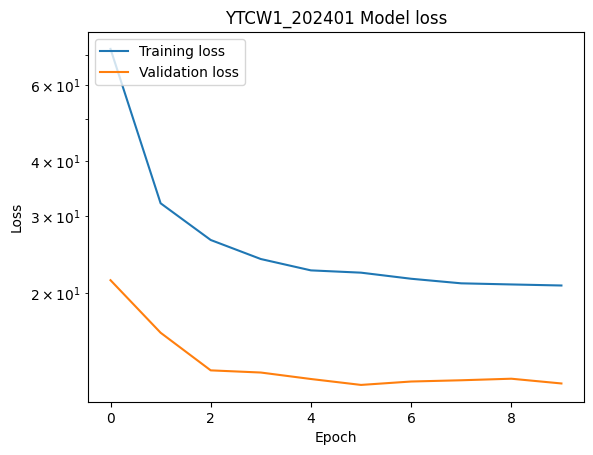

Fitted Weights Hash: 4c2b9ac9d98789980e119b1461c6b557
Predicting Training through Test
All X hash: 9de16eb640f0705ddcb39ee790ea1f57
Predicting
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Predictions Hash: c636052c3fa47a225bb1ff8496db4279


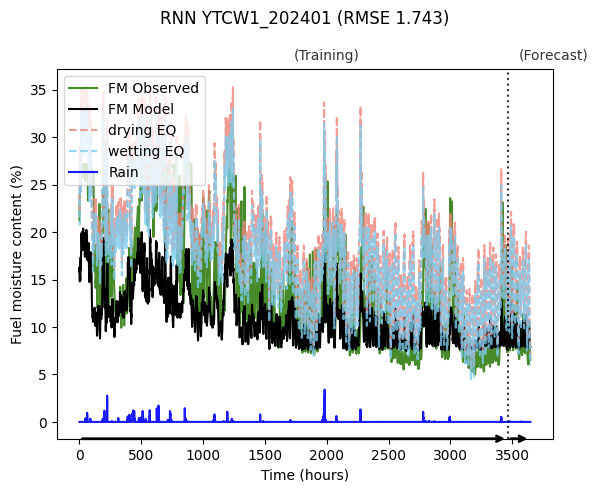

In [53]:
m, errs = rnn.run_model(rnn_dat)

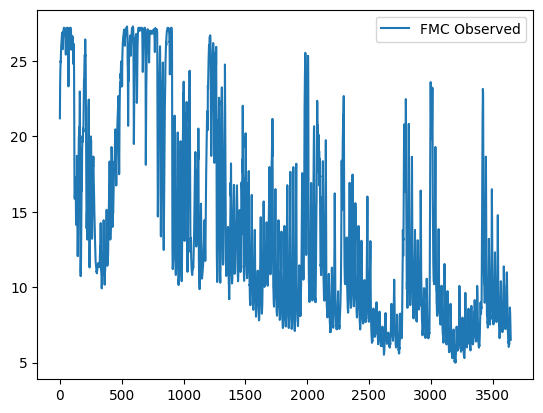

In [64]:
plt.plot(rnn_dat.y, label = "FMC Observed")
plt.legend()

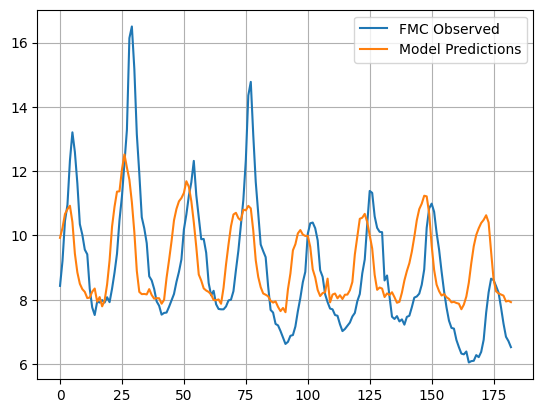

In [63]:
plt.plot(rnn_dat.y[rnn_dat.test_ind:], label = "FMC Observed")
plt.plot(rnn_dat.m[rnn_dat.test_ind:], label = "Model Predictions")
plt.legend()
plt.grid()

In [ ]:
# rnn.fit(rnn_dat.X_train[0:150,:], rnn_dat.y_train[0:150,:])

In [ ]:
# rnn.model_train.get_weights()

## Test RNN

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import read_pkl

In [ ]:
train = read_pkl("train.pkl")

In [ ]:
params = read_yml("params.yaml", subkey="rnn")
params = RNNParams(params)

In [ ]:
params.update({'activation': ['linear', 'linear'], 'epochs':300, 'val_frac': .2, 'scaler': 'minmax', 'rnn_layers': 1, 'dense_layers': 1})

In [ ]:
rnn_dat = RNNData(train['NV020_202401'], scaler = params['scaler'], features_list = params['features_list'])

In [ ]:
rnn_dat.train_test_split(
    train_frac = params['train_frac'],
    val_frac = params['val_frac']
)

In [ ]:
rnn_dat.scale_data()

In [ ]:
import importlib
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN

In [ ]:
rnn = RNN(params)

In [ ]:
rnn.predict(rnn_dat.X_test)

In [ ]:
rnn.model_predict.summary()

In [ ]:
reproducibility.set_seed(123)
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat)

## Test Data Creation

In [ ]:
import importlib
import moisture_rnn_pkl
importlib.reload(moisture_rnn_pkl)
from moisture_rnn_pkl import pkl2train

In [ ]:
file_names=['test_CA_202401.pkl', 'test_NW_202401.pkl']
file_dir='data'
file_paths = [osp.join(file_dir,file_name) for file_name in file_names]

In [ ]:
train = pkl2train(file_paths)

In [ ]:
train.keys()

## Test RNN

In [ ]:
errs

In [ ]:
import importlib 
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN

In [ ]:
params = read_yml("params.yaml", subkey="rnn")
params = RNNParams(params)

In [ ]:
reproducibility.set_seed()
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat)

## LSTM

TODO: FIX BELOW

In [ ]:
import importlib 
import moisture_rnn
importlib.reload(moisture_rnn)
from moisture_rnn import RNN_LSTM

In [ ]:
with open("params.yaml") as file:
    params = yaml.safe_load(file)["lstm"]
    
rnn_dat2 = create_rnn_data2(train[case],params)

In [ ]:
params.update({'epochs': 10})

In [ ]:
reproducibility.set_seed()
rnn = RNN(params)
m, errs = rnn.run_model(rnn_dat2)

In [ ]:
import importlib
importlib.reload(moisture_rnn)
from moisture_rnn import RNN_LSTM

In [ ]:
with open("params.yaml") as file:
    params = yaml.safe_load(file)["lstm"]

rnn_dat2 = create_rnn_data2(train[case],params)
params

In [ ]:
params.update({
    'learning_rate': 0.000001,
    'epochs': 10,
    'clipvalue':1.0
})

In [ ]:
reproducibility.set_seed()
lstm = RNN_LSTM(params)
m, errs = lstm.run_model(rnn_dat2)